In [21]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
import models.models as models
import util.generation as generation


In [23]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [24]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [25]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}


def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [26]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [27]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

he name of this book a collection of logic puzzles exploring this theme paradoxes louch bem or loucherbem is parisian and lyonna

overage internet site of the week bangkok post october two seven two zero zero four in english encourages thais to contribute to

jump into university courses usually what is achieved in u s colleges this decision of the german states seriously impairs inter

cardboard of the bottom cell alessandro giuseppe antonio anastasio volta portrait honors in honor of his work in the field of el

anguage discouraged forms to be falls in the set of irregular verbs in english some individuals especially those who have learne



# Create a basic Transformer model

In [28]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [29]:
# vocab size
vocab_size = len(char_set)

# internal model dimensions
d_model = 256

# number of attention heads
n_heads = 8

# number of Transformer layers
n_layers = 2

# maximum sequence length
max_len = 128

model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)

In [30]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))


print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 1_624_576


In [31]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [32]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [33]:
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics


# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [34]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [35]:
niter = 100_000
B, T = 128, 32
warmup_steps = 2_000
decay_steps = max(1, niter - warmup_steps)

# define optax optimizer
learning_rate = 0.001

lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=learning_rate,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    end_value=0.0,
)

# Create Adam optimizer (Optax)
# tx = optax.adam(learning_rate=learning_rate)
tx = optax.chain(
    optax.clip_by_global_norm(1.0),    # Optional gradient clipping
    optax.adamw(
        learning_rate=lr_schedule,     # ← Use schedule here
        b1=0.9,
        b2=0.95,
        eps=1e-8,
        weight_decay=0.1,
    ),
)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: Adam lr={learning_rate}")


Initialized optimizer: Adam lr=0.001


In [36]:
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
time_start = time.time()
for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']
        loss_test_history.append(test_loss)
        time_test_history.append(time_since_start)
        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()


iteration 0  time: 7.9 seconds
	 	 loss(train :: test): 3.9772 :: 3.9389
	 	 accuracy (train :: test): 2.1% :: 2.4%
	 	 accuracy (last character) (train :: test): 2.3% :: 2.4%

iteration 2_000  time: 14.7 seconds
	 	 loss(train :: test): 1.5024 :: 1.5698
	 	 accuracy (train :: test): 53.9% :: 51.7%
	 	 accuracy (last character) (train :: test): 56.2% :: 53.1%

iteration 4_000  time: 21.2 seconds
	 	 loss(train :: test): 1.4924 :: 1.4520
	 	 accuracy (train :: test): 53.9% :: 55.2%
	 	 accuracy (last character) (train :: test): 53.1% :: 57.6%

iteration 6_000  time: 27.8 seconds
	 	 loss(train :: test): 1.3910 :: 1.4275
	 	 accuracy (train :: test): 56.8% :: 55.4%
	 	 accuracy (last character) (train :: test): 64.1% :: 56.9%

iteration 8_000  time: 34.5 seconds
	 	 loss(train :: test): 1.3964 :: 1.4408
	 	 accuracy (train :: test): 57.1% :: 55.1%
	 	 accuracy (last character) (train :: test): 60.9% :: 57.7%

iteration 10_000  time: 41.1 seconds
	 	 loss(train :: test): 1.4364 :: 1.4137


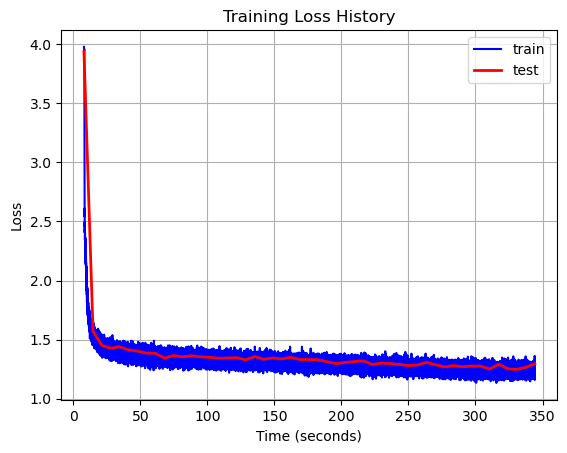

In [39]:
# plot the loss history
import matplotlib.pyplot as plt
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

In [38]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]]], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
# print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

2025-10-25 20:55:59.952663: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-10-25 20:55:59.952694: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


generated ids shape: (1, 1000)
generated text:
hello my fri il sh inmo aseloh sh ai danelalanigapnanaddestt mesteischouce a riz a is w da pounedor tt me ca g palanonora se inerdrig ay knonisth garaid w bon atris a an koulit re ams re car onach ibizglou t ana nanapp w cetola inocononene dopare toreneisenes l stolors m e faninig pa phos tt a mas inec be oramischonechoralese kapazra iconer sie ats doly a corenoris is esidera papanalugachase an ousteraleris his or tinas as teunaprigane wo s binenaxle accharnounorinis ar idina aniliame bs tone n ia thahu asth boneh a fouth aton oninech da cha gule araleyddamanenethalananari s t inere mad w a f s ouni t p s laloreniseralido m are bocau f in cho s ie a a c nonanalerda iralich bunasthareyth fone oune ciga c aratuleneneus cchat pes s m anin bla s ora bereleli lophinorifo thas wasor br at couker pano m cefochareroninolabes chet mamad oresinotorides s m e sem thones s lera mid c s honolareqs s p onoremevex chas minor s we w a otwe finenmanos f al